<a href="https://colab.research.google.com/github/juhumkwon/DeepLearning/blob/main/CL_09_02_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 34ms/step - kl_loss: 117.5034 - loss: 138.0143 - recon_loss: 137.8967 - val_loss: 0.0200
Epoch 2/50
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 18ms/step - kl_loss: 80.2679 - loss: 91.2924 - recon_loss: 91.2121 - val_loss: 0.0163
Epoch 3/50
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 18ms/step - kl_loss: 72.4858 - loss: 86.2979 - recon_loss: 86.2254 - val_loss: 0.0151
Epoch 4/50
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 18ms/step - kl_loss: 69.8518 - loss: 83.9247 - recon_loss: 83.8548 - val_loss: 0.0146
Epoch 5/50
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 17ms/step - kl_loss: 68.7001 - loss: 82.2944 - recon_loss: 82.2257 - val_loss: 0.0140
Epoch 6/50
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 17ms/step - kl_loss: 67.3372 - loss: 81.1153 - recon_loss: 81.0480 

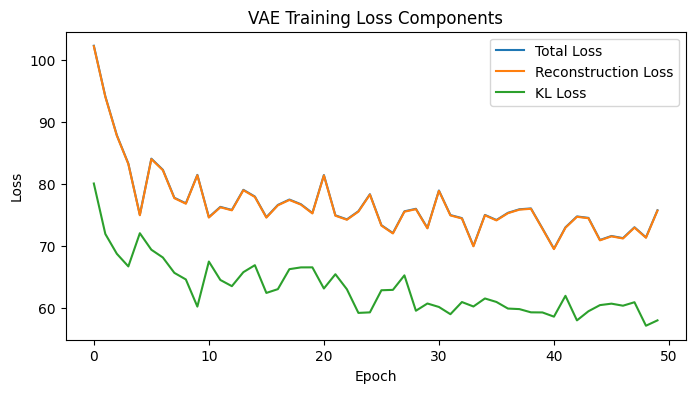

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step


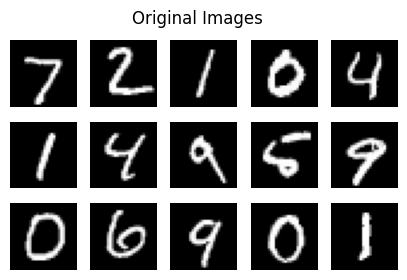

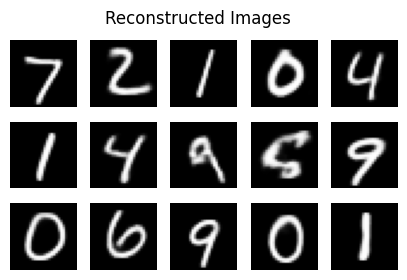

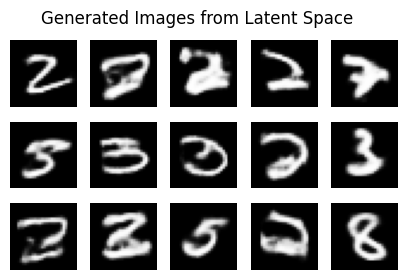

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 1Ô∏è‚É£ Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
# ===============================
(x_train, _), (x_valid, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_valid = x_valid.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_valid = np.reshape(x_valid, (-1, 28, 28, 1))

# ÌïòÏù¥perparameters
latent_dim = 8              # Latent space dimension (improves reconstruction quality)
learning_rate = 0.002       # Slightly increased
batch_size = 128
epochs = 50
kl_weight = 0.001           # KL loss weight (important!)

# ===============================
# 2Ô∏è‚É£ Encoder Definition
# ===============================
def build_encoder():
    encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    return tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# ===============================
# 3Ô∏è‚É£ Sampling Layer Definition
# ===============================
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs           # Ïù∏ÏΩîÎçîÏùò Ï∂úÎ†• (ÌèâÍ∑†, Î°úÍ∑∏Î∂ÑÏÇ∞)
        batch = tf.shape(z_mean)[0]          # Î∞∞Ïπò ÌÅ¨Í∏∞
        dim = tf.shape(z_mean)[1]            # Ïû†Ïû¨Í≥µÍ∞Ñ Ï∞®Ïõê Ïàò
        epsilon = tf.random.normal(shape=(batch, dim))   # ÌëúÏ§ÄÏ†ïÍ∑úÎ∂ÑÌè¨ÏóêÏÑú ÎûúÎç§ ÏÉòÌîåÎßÅ
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ===============================
# 4Ô∏è‚É£ Decoder Definition
# ===============================
def build_decoder():
    decoder_inputs = tf.keras.Input(shape=(latent_dim,)) #Ïû†Ïû¨Í≥µÍ∞Ñ(latent space)ÏóêÏÑú ÏûÖÎ†•Î∞õÎäî Î≤°ÌÑ∞ z (Ïòà: ÌÅ¨Í∏∞ latent_dim)
    x = layers.Dense(7 * 7 * 128, activation="relu")(decoder_inputs) #ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ(Dense): Ïû†Ïû¨Î≤°ÌÑ∞ zÎ•º 7√ó7√ó128 ÌÅ¨Í∏∞Ïùò feature mapÏúºÎ°ú ÌôïÏû•
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x) # 7√ó7 ‚Üí 14√ó14 Î°ú ÌÅ¨Í∏∞Î•º 2Î∞∞Î°ú ÌôïÏû•ÌïòÎ©∞ ÌäπÏßï Î≥µÏõê
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) # 14√ó14 ‚Üí 28√ó28 Î°ú ÌôïÏû•, Ï±ÑÎÑê ÏàòÎ•º 64Î°ú Ï§ÑÏó¨ ÏÑ∏Î∂Ä Íµ¨Ï°∞ Î≥µÏõê
    x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)  # ÏÑ∏Î∞ÄÌïú Ìå®ÌÑ¥ÏùÑ Î≥¥Í∞ï, feature mapÏùò ÌíàÏßà Í∞úÏÑ†
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x) # Ï∂úÎ†• Ï±ÑÎÑê ÏàòÎ•º 1Î°ú Ï§ÑÏó¨ ÏµúÏ¢Ö Î≥µÏõê Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ± (28√ó28√ó1)
    return tf.keras.Model(decoder_inputs, decoder_outputs, name="decoder")

# ===============================
# 5Ô∏è‚É£ VAE Model Definition (custom train_step)
# ===============================
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, kl_weight=0.001, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.kl_weight = kl_weight

    def train_step(self, data):
        # Unpack the data if it's a tuple (as passed by vae.fit)
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling([z_mean, z_log_var])
            reconstruction = self.decoder(z)

            # Reconstruction loss (binary crossentropy)
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.backend.binary_crossentropy(data, reconstruction),
                    axis=(1, 2, 3) # (1, 2, 3)ÏùÄ batchÎ•º Ï†úÏô∏Ìïú Î™®Îì† Ï∞®ÏõêÏùÑ ÎúªÌï©ÎãàÎã§.
                )
            )

            # KL loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            total_loss = recon_loss + self.kl_weight * kl_loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"loss": total_loss, "recon_loss": recon_loss, "kl_loss": kl_loss}

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        return self.decoder(z)

# ===============================
# 6Ô∏è‚É£ Instance Creation and Compilation
# ===============================
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder, kl_weight=kl_weight)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.MeanSquaredError())

# ===============================
# 7Ô∏è‚É£ Training
# ===============================
history = vae.fit(
    x_train, x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_valid, x_valid),
    verbose=1
)

# ===============================
# 8Ô∏è‚É£ Training Results Visualization
# ===============================
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['recon_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.title("VAE Training Loss Components")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ===============================
# 9Ô∏è‚É£ Image Reconstruction and Generation
# ===============================
def plot_images(images, n_rows, n_cols, title=""):
    plt.figure(figsize=(n_cols, n_rows))
    plt.suptitle(title)
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

# ‚úÖ Check reconstructed images
decoded_imgs = vae.predict(x_valid[:15])
plot_images(x_valid[:15], 3, 5, "Original Images")
plot_images(decoded_imgs, 3, 5, "Reconstructed Images")

# ‚úÖ Generate from latent space
"""
Ïû†Ïû¨Í≥µÍ∞Ñ(latent space)ÏóêÏÑú Î¨¥ÏûëÏúÑÎ°ú Ï†êÎì§ÏùÑ ÏÉòÌîåÎßÅÌï©ÎãàÎã§.
latent_dim: Ïû†Ïû¨Í≥µÍ∞ÑÏùò Ï∞®Ïõê Ïàò (Ïòà: 2, 16, 32 Îì±)
Í∞Å z Î≤°ÌÑ∞Îäî ÌëúÏ§ÄÏ†ïÍ∑úÎ∂ÑÌè¨
ùëÅ(0,ùêº)
N(0,I)ÏóêÏÑú ÎΩëÏùÄ Í∞íÏûÖÎãàÎã§.
Ï¶â, ÌïôÏäµÎêú VAEÏùò Ïû†Ïû¨Í≥µÍ∞ÑÏóê Î¨¥ÏûëÏúÑÎ°ú Ï†êÏùÑ Ï∞çÏùÄ Í≤ÉÏûÖÎãàÎã§.
"""
n_images = 15
codings = tf.random.normal(shape=[n_images, latent_dim])
generated_images = vae.decoder(codings).numpy()
plot_images(generated_images, 3, 5, "Generated Images from Latent Space")